<div style="text-align: center;">
    <h1> <font style="bold"> Trabajo Práctico Integrador </font></h1>
    <h2><font style="bold">Visión por Computadora II - CEIA </font></h2>
    <h3><font style="bold">Abril Noguera - Pedro Barrera - Ezequiel Caamaño</font></h3>
</div>

# Detección Automatizada de Cáncer de Pulmón mediante Visión por Computadora

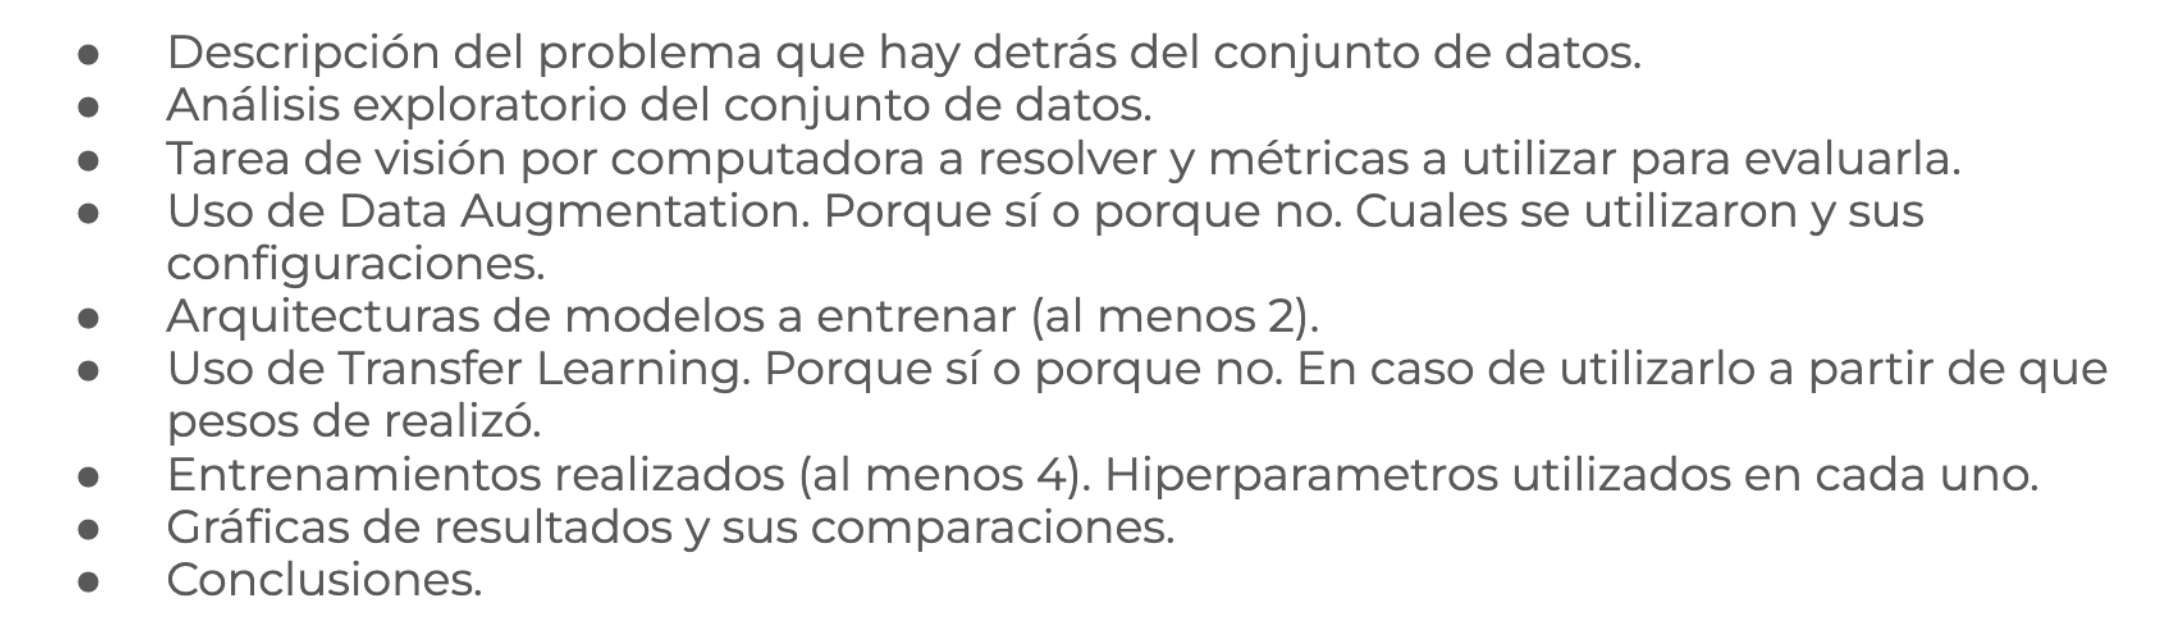

## Business Case

**Motivación:**

El cáncer de pulmón es una de las principales causas de muerte a nivel mundial. Su detección temprana es crucial para mejorar el pronóstico y las posibilidades de tratamiento de los pacientes. Sin embargo, los métodos tradicionales de diagnóstico dependen fuertemente de la interpretación humana de imágenes médicas, lo cual puede estar sujeto a errores, demoras y variabilidad entre profesionales.

Ante este desafío, las técnicas de visión por computadora y aprendizaje automático ofrecen una oportunidad: automatizar la detección y clasificación de distintos tipos de cáncer pulmonar a partir de imágenes, asistiendo al cuerpo médico en el proceso diagnóstico y permitiendo un análisis más rápido, objetivo y escalable.

**Objetivo:**

Desarrollar un sistema inteligente basado en redes neuronales convolucionales (CNN) que sea capaz de analizar imágenes de tomografías de tórax (CT-Scans) y:
- Detectar si el paciente presenta o no signos de cáncer.
- Clasificar el tipo de cáncer entre:
    - *Adenocarcinoma:* es la forma más común de cáncer de pulmón, representando aproximadamente el 30% de todos los casos y cerca del 40% de los casos de cáncer de pulmón de células no pequeñas (NSCLC).
    - *Carcinoma de células grandes:* es un tipo de cáncer de pulmón que crece y se disemina rápidamente, y puede aparecer en cualquier parte del pulmón. Representa entre el 10% y el 15% de los casos de cáncer de pulmón de células no pequeñas.
    - *Carcinoma de células escamosas:* se localiza en la parte central del pulmón, generalmente donde los bronquios principales se conectan con la tráquea o en una de las principales ramas de las vías respiratorias.

**Justificación:**

Este proyecto tiene un fuerte impacto potencial en varios niveles:

*Impacto Clínico:*
- Reducción del tiempo diagnóstico.
- Mayor precisión y objetividad al identificar tipos específicos de cáncer.
- Asistencia a radiólogos y oncólogos con una herramienta complementaria.

*Impacto Social:*
- Mejora en la calidad de vida de los pacientes mediante una detección temprana.
- Democratización del acceso al diagnóstico, especialmente en regiones con escasez de especialistas.

*Impacto Económico:*
- Reducción de costos médicos derivados de diagnósticos tardíos o tratamientos inadecuados.
- Optimización de recursos en instituciones de salud.

## Exploratory Data Analysis

### Importación de Librerias

In [30]:
import kagglehub
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
import numpy as np

### Importación del Dataset

**Descripción del Dataset**

Se utilizó el dataset **Chest CT Scan Images** disponible en [Kaggle](https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images). Contiene imágenes de tomografías de tórax clasificadas en:

- Adenocarcinoma  
- Carcinoma de células grandes  
- Carcinoma de células escamosas  
- Células normales

Las imágenes están en formato `.jpg` o `.png`, y se organizan en tres subconjuntos: `train` (70%), `valid` (10%) y `test` (20%).

> Fuente: [Mohamed Hany – Chest CT Scan Images Dataset](https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images)

In [31]:
# Download latest version
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")

print("Path to dataset files:", path)

Path to dataset files: /Users/ezequiel/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1


In [32]:
# Ruta al directorio "Data" que contiene train/valid/test
data_dir = os.path.join(path, "Data")

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # redimensionar imágenes
    transforms.ToTensor(),           # convertir a tensor
])

# Cargar datasets desde carpetas
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "valid"), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(data_dir, "test"),  transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

### Introducción General

In [33]:
# Cantidad de Imágenes
print("Cantidad de imágenes en el conjunto de entrenamiento:", len(train_dataset))
print("Cantidad de imágenes en el conjunto de validación:", len(valid_dataset))
print("Cantidad de imágenes en el conjunto de prueba:", len(test_dataset))

Cantidad de imágenes en el conjunto de entrenamiento: 613
Cantidad de imágenes en el conjunto de validación: 72
Cantidad de imágenes en el conjunto de prueba: 315


In [34]:
# Clases detectadas
print("Clases Train:", train_dataset.classes)
print("Clases Validación:", valid_dataset.classes)
print("Clases Test:", test_dataset.classes)

Clases Train: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
Clases Validación: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
Clases Test: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


Los nombres de clases estan definidos distintos en los distintos datasets, los normalizamos con los nombres de test.

In [35]:
# Ruta base del dataset descargado con kagglehub
data_dir = os.path.join(path, "Data")

# Mapeo de nombres actuales → nombres corregidos
renombrar_clases = {
    'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 'adenocarcinoma',
    'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 'large.cell.carcinoma',
    'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 'squamous.cell.carcinoma'
    # 'normal' ya está bien
}

# Aplicar cambios a cada partición
for split in ['train', 'valid', 'test']:
    split_dir = os.path.join(data_dir, split)

    for folder_name in os.listdir(split_dir):
        folder_path = os.path.join(split_dir, folder_name)

        if os.path.isdir(folder_path) and folder_name in renombrar_clases:
            new_name = renombrar_clases[folder_name]
            new_path = os.path.join(split_dir, new_name)

            if os.path.exists(new_path):
                # Mover contenido si ya existe la carpeta destino
                for file in os.listdir(folder_path):
                    shutil.move(os.path.join(folder_path, file), new_path)
                os.rmdir(folder_path)
            else:
                # Renombrar directamente si no existe destino
                os.rename(folder_path, new_path)

# Cargar datasets desde carpetas
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "valid"), transform=transform)
test_dataset  = datasets.ImageFolder(root=os.path.join(data_dir, "test"),  transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

# Clases detectadas
print("Clases Train:", train_dataset.classes)
print("Clases Validación:", valid_dataset.classes)
print("Clases Test:", test_dataset.classes)

Clases Train: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
Clases Validación: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']
Clases Test: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


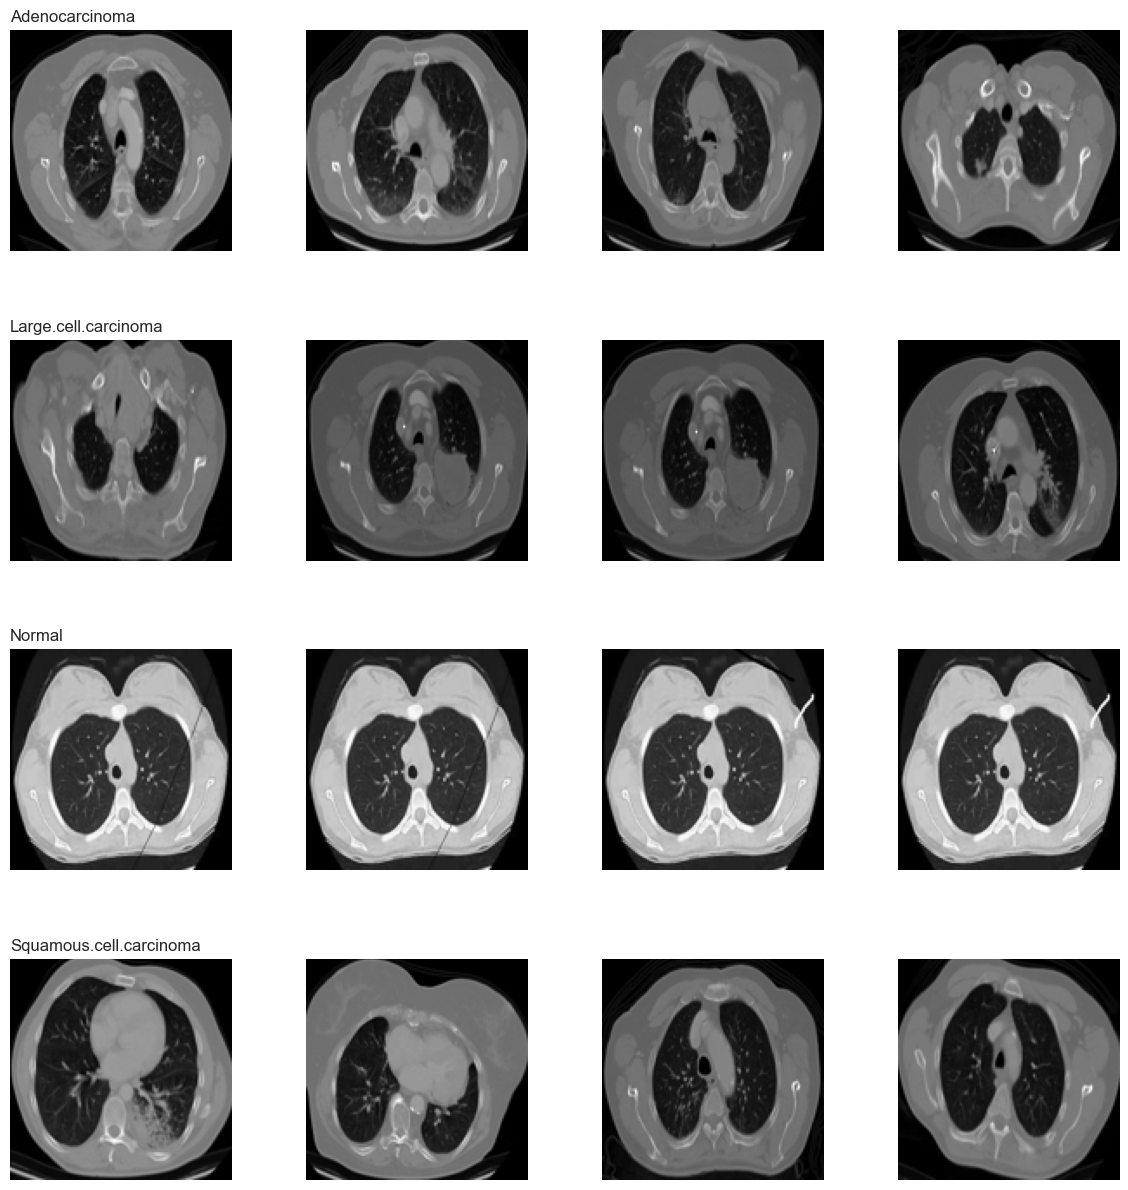

In [36]:
def mostrar_muestras(base_dir, split='train', clases=None, muestras_por_clase=4, size=(128, 128)):
    if clases is None:
        clases = sorted(os.listdir(os.path.join(base_dir, split)))

    n_clases = len(clases)
    fig, axs = plt.subplots(n_clases, muestras_por_clase, figsize=(muestras_por_clase * 3, n_clases * 3))

    for i, clase in enumerate(clases):
        clase_dir = os.path.join(base_dir, split, clase)
        imagenes = sorted(os.listdir(clase_dir))[:muestras_por_clase]

        for j in range(muestras_por_clase):
            ax = axs[i, j] if n_clases > 1 else axs[j]
            img_path = os.path.join(clase_dir, imagenes[j])
            img = Image.open(img_path).convert("L").resize(size)

            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                ax.set_title(clase.replace("_", " ").capitalize(), fontsize=12, loc='left')

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

mostrar_muestras(data_dir, split='train', muestras_por_clase=4)

Después de ver algunas imágenes de cada clase, se pueden hacer las siguientes observaciones:

- **Las imágenes son similares en formato:** todas son tomografías de tórax (CT scans) en blanco y negro, vistas desde arriba.

- **Las diferencias entre clases no son tan obvias a simple vista:** es difícil ver qué imágenes tienen cáncer y cuáles no, o qué tipo de cáncer es. Por eso es importante usar inteligencia artificial para detectar patrones que no son tan evidentes para las personas.

- **Imágenes normales vs. con cáncer:** Las tomografías de personas sanas muestran pulmones con formas limpias y simétricas. En cambio, en las imágenes con cáncer se pueden ver zonas oscuras o manchas que podrían indicar tumores o anormalidades.

- **Ubicación del cáncer según el tipo**  
   - El **adenocarcinoma** suele aparecer en las zonas externas del pulmón.
   - El **carcinoma de células grandes** puede estar en cualquier parte.
   - El **carcinoma de células escamosas** se ve más en el centro del pulmón.  
   Estas ubicaciones podrían ayudar al modelo a identificar cada tipo.

### Desbalance de Clases

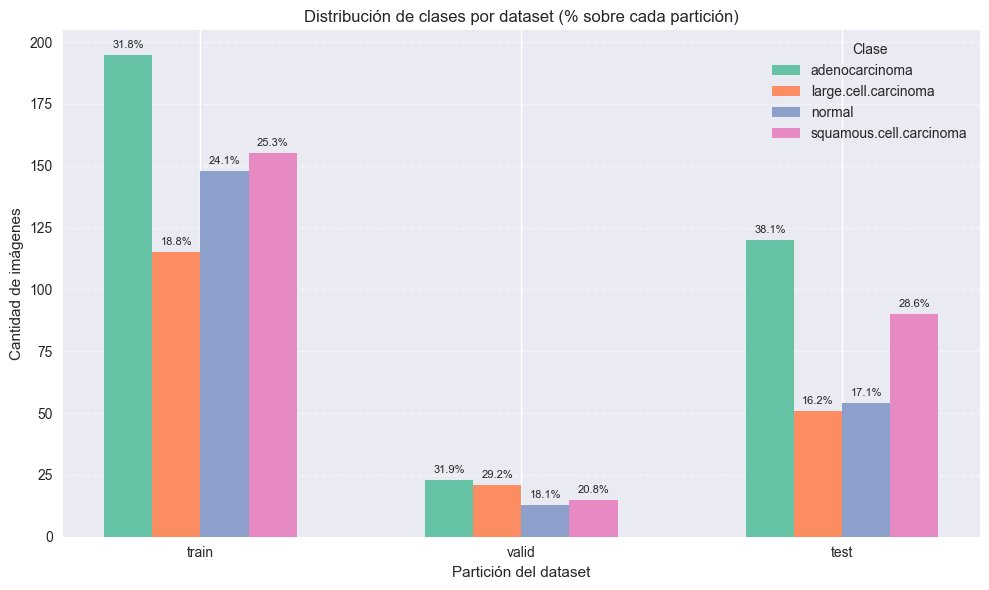

In [37]:
def contar_imagenes_por_clase(base_dir):
    particiones = ['train', 'valid', 'test']
    conteo = defaultdict(dict)

    for split in particiones:
        split_dir = os.path.join(base_dir, split)
        for clase in os.listdir(split_dir):
            clase_dir = os.path.join(split_dir, clase)
            if os.path.isdir(clase_dir):
                conteo[split][clase] = len(os.listdir(clase_dir))
    return conteo

def graficar_distribucion_conteo_por_dataset(conteo):
    particiones = ['train', 'valid', 'test']
    clases = sorted(list(set(k for v in conteo.values() for k in v)))
    colores = plt.get_cmap('Set2').colors[:len(clases)]

    x = range(len(particiones))  # eje X: datasets
    bar_width = 0.15

    plt.figure(figsize=(10, 6))

    for i, clase in enumerate(clases):
        valores = [conteo[split].get(clase, 0) for split in particiones]
        totales = [sum(conteo[split].values()) for split in particiones]
        porcentajes = [100 * v / t if t > 0 else 0 for v, t in zip(valores, totales)]

        # Desplazamiento para cada clase
        bar_pos = [p + bar_width*i - (bar_width * (len(clases)-1)/2) for p in x]
        bars = plt.bar(bar_pos, valores, width=bar_width, label=clase, color=colores[i])

        # Agregar porcentaje como texto encima de la barra
        for rect, pct in zip(bars, porcentajes):
            plt.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 2,
                     f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)

    plt.xticks(x, particiones)
    plt.xlabel('Partición del dataset')
    plt.ylabel('Cantidad de imágenes')
    plt.title('Distribución de clases por dataset (% sobre cada partición)')
    plt.legend(title='Clase')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Ejecutar
data_dir = os.path.join(path, "Data")
conteo = contar_imagenes_por_clase(data_dir)
graficar_distribucion_conteo_por_dataset(conteo)

Al analizar la cantidad de imágenes por clase en cada partición (`train`, `valid`, `test`), se observan las siguientes conclusiones:

- El dataset presenta **ligero desbalance** entre clases, aunque todas están razonablemente representadas.
- La clase **adenocarcinoma** es la más frecuente en las tres particiones, especialmente en `test` (38.1%).
- La clase **large.cell.carcinoma** es la menos representada, con apenas el 16–18% en `train` y `test`.
- La clase **normal** mantiene una distribución estable en todas las particiones.
- Este desbalance podría afectar el rendimiento del modelo, especialmente en clases menos representadas, por lo que sería recomendable considerar:
  - Técnicas de **data augmentation** específicas para clases minoritarias.
  - Uso de **pesos balanceados** en la función de pérdida.

### Análisis de Distribución de Colores

Todas las imágenes del dataset están en **escala de grises** (blanco y negro), ya que se trata de tomografías computarizadas (CT Scans) del tórax. Este tipo de imágenes médicas no contiene información de color (RGB), sino que representa distintos niveles de densidad en tonos de gris.

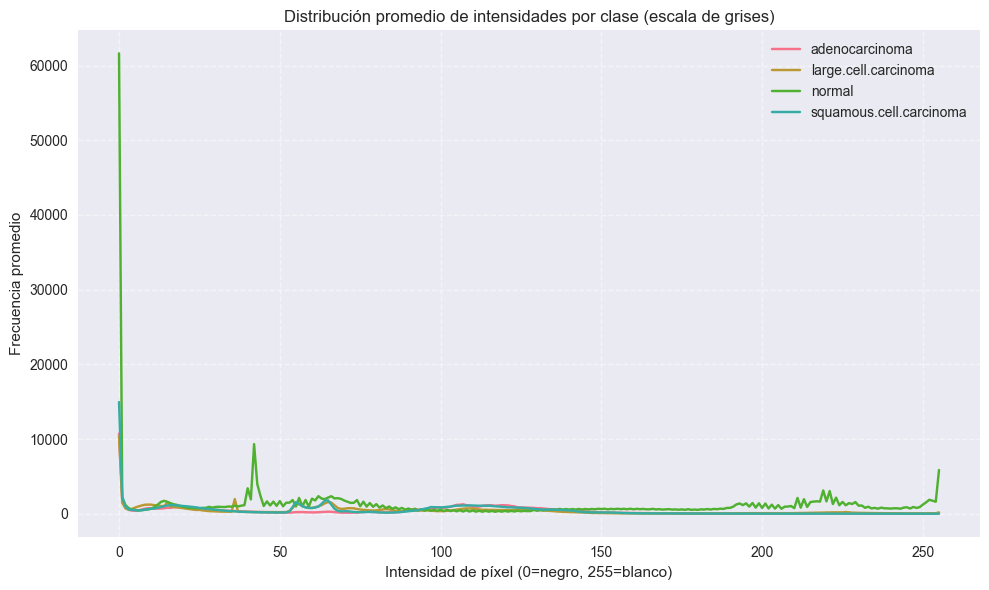

In [38]:
def obtener_histograma_promedio(clase_dir, max_imgs=50):
    hist_total = np.zeros(256)
    archivos = os.listdir(clase_dir)[:max_imgs]

    for archivo in archivos:
        img_path = os.path.join(clase_dir, archivo)
        img = Image.open(img_path).convert("L")  # escala de grises
        arr = np.array(img).flatten()
        hist, _ = np.histogram(arr, bins=256, range=(0, 255))
        hist_total += hist

    hist_total /= len(archivos)
    return hist_total

def graficar_histogramas_por_clase(data_dir, split='train', max_imgs=50):
    clases = sorted(os.listdir(os.path.join(data_dir, split)))
    plt.figure(figsize=(10, 6))

    for clase in clases:
        clase_dir = os.path.join(data_dir, split, clase)
        hist = obtener_histograma_promedio(clase_dir, max_imgs=max_imgs)
        plt.plot(hist, label=clase)

    plt.title("Distribución promedio de intensidades por clase (escala de grises)")
    plt.xlabel("Intensidad de píxel (0=negro, 255=blanco)")
    plt.ylabel("Frecuencia promedio")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

graficar_histogramas_por_clase(data_dir, split='train')

El histograma de intensidad promedio por clase revela diferencias sutiles pero significativas entre imágenes normales y con distintos tipos de cáncer:

- Las **imágenes normales** muestran:
  - Un **pico muy alto en el valor 0**, lo que representa zonas totalmente negras (como el aire en los pulmones).
  - Dos picos más entre los valores **40–50** y **180–255**, que podrían ser partes normales como tejidos blandos y huesos.

- Las **imágenes con cáncer** tienen:
  - **Muchos valores entre 50 y 80**, lo que podría estar relacionado con zonas anormales dentro del pulmón.
  - Un aumento claro entre **90 y 140**, que probablemente representa tumores u otras alteraciones.

Estas diferencias en la distribución de grises entre imágenes normales y con cáncer podrían ser claves para que el modelo aprenda a diferenciarlas. Aunque no son diferencias visualmente evidentes, un modelo de CNN puede capturarlas como patrones relevantes.

Por eso, **es útil normalizar las intensidades** y dejar que el modelo aproveche estas variaciones como señales predictivas.

### Análisis de Bounding Boxes

### Análisis de Distribución de Etiquetas

### Dimensión de Imágenes y Relación de Aspecto

=== ANÁLISIS DE DIMENSIONES Y RELACIÓN DE ASPECTO ===
Procesando 613 imágenes del dataset Train...

Train Set:
  Número de imágenes: 613
  Dimensiones mínimas: (172, 110)
  Dimensiones máximas: (1200, 874)
  Relación de aspecto mínima: 1.00
  Relación de aspecto máxima: 2.60
Procesando 72 imágenes del dataset Valid...

Valid Set:
  Número de imágenes: 72
  Dimensiones mínimas: (345, 192)
  Dimensiones máximas: (940, 627)
  Relación de aspecto mínima: 1.00
  Relación de aspecto máxima: 2.05
Procesando 315 imágenes del dataset Test...

Test Set:
  Número de imágenes: 315
  Dimensiones mínimas: (371, 251)
  Dimensiones máximas: (940, 627)
  Relación de aspecto mínima: 1.00
  Relación de aspecto máxima: 1.84


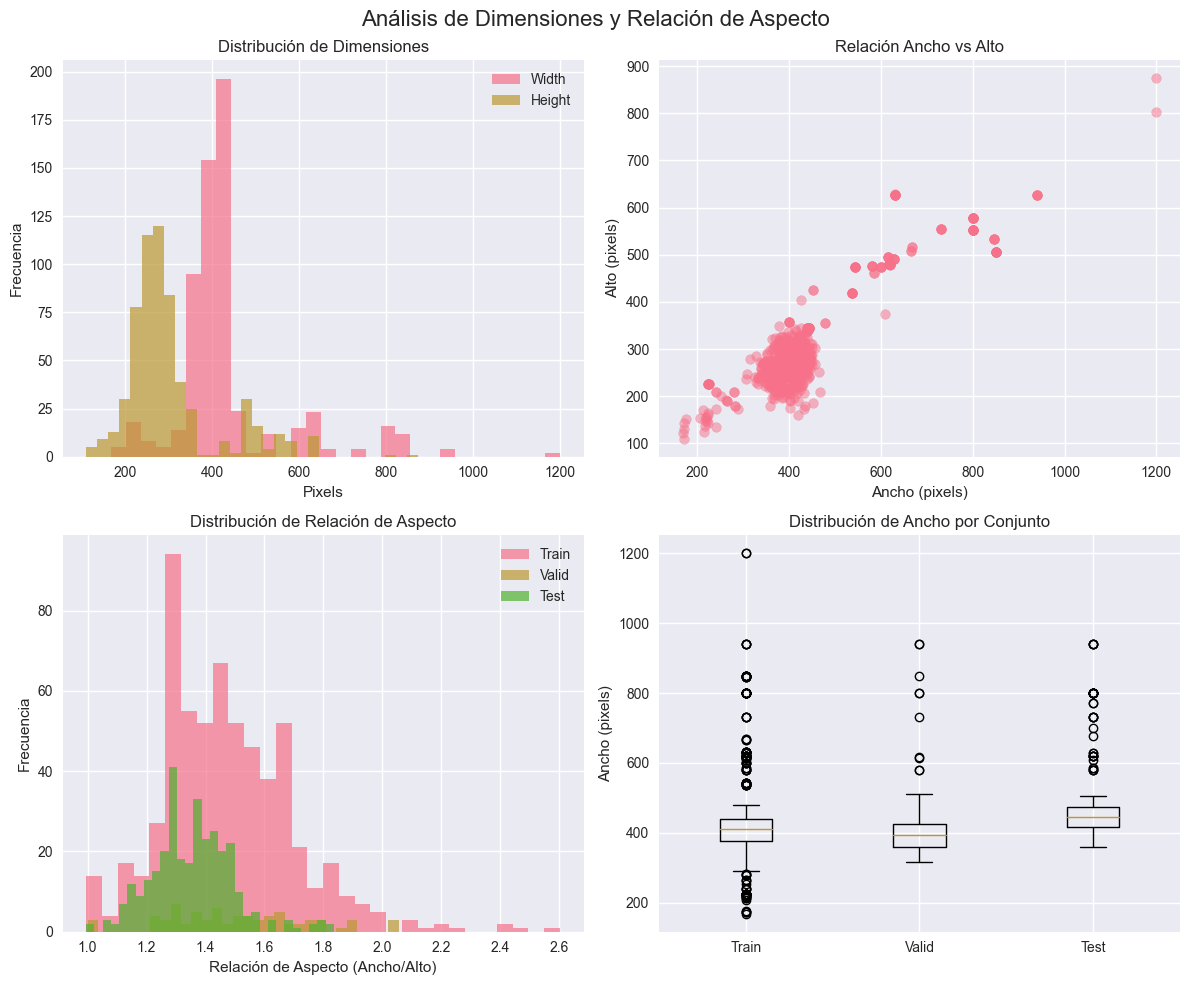


=== RESUMEN GENERAL ===
Dimensiones de las imágenes:
  Train: (172, 110) a (1200, 874)
  Valid: (345, 192) a (940, 627)
  Test: (371, 251) a (940, 627)

Relaciones de aspecto:
  Train: 1.00 a 2.60
  Valid: 1.00 a 2.05
  Test: 1.00 a 1.84


In [39]:
def analyze_image_dimensions(dataset, dataset_name, sample_size=1000):
    """
    Analiza las dimensiones y relaciones de aspecto de las imágenes en un dataset
    """
    dimensions = []
    aspect_ratios = []
    
    # Tomar una muestra razonable de imágenes (no todas para evitar lentitud)
    max_samples = min(sample_size, len(dataset))
    
    print(f"Procesando {max_samples} imágenes del dataset {dataset_name}...")
    
    for i in range(max_samples):
        # Obtener la imagen sin transformación para análisis de dimensiones
        img_path = dataset.samples[i][0]
        with Image.open(img_path) as img:
            width, height = img.size
            dimensions.append((width, height))
            aspect_ratio = width / height if height != 0 else 0
            aspect_ratios.append(aspect_ratio)
    
    return dimensions, aspect_ratios


# Análisis de dimensiones y relación de aspecto
print("=== ANÁLISIS DE DIMENSIONES Y RELACIÓN DE ASPECTO ===")
# Analizar train set
train_dims, train_aspect_ratios = analyze_image_dimensions(train_dataset, "Train")
print(f"\nTrain Set:")
print(f"  Número de imágenes: {len(train_dims)}")
print(f"  Dimensiones mínimas: {min(train_dims, key=lambda x: x[0]*x[1])}")
print(f"  Dimensiones máximas: {max(train_dims, key=lambda x: x[0]*x[1])}")
print(f"  Relación de aspecto mínima: {min(train_aspect_ratios):.2f}")
print(f"  Relación de aspecto máxima: {max(train_aspect_ratios):.2f}")

# Analizar valid set
valid_dims, valid_aspect_ratios = analyze_image_dimensions(valid_dataset, "Valid")
print(f"\nValid Set:")
print(f"  Número de imágenes: {len(valid_dims)}")
print(f"  Dimensiones mínimas: {min(valid_dims, key=lambda x: x[0]*x[1])}")
print(f"  Dimensiones máximas: {max(valid_dims, key=lambda x: x[0]*x[1])}")
print(f"  Relación de aspecto mínima: {min(valid_aspect_ratios):.2f}")
print(f"  Relación de aspecto máxima: {max(valid_aspect_ratios):.2f}")

# Analizar test set
test_dims, test_aspect_ratios = analyze_image_dimensions(test_dataset, "Test")
print(f"\nTest Set:")
print(f"  Número de imágenes: {len(test_dims)}")
print(f"  Dimensiones mínimas: {min(test_dims, key=lambda x: x[0]*x[1])}")
print(f"  Dimensiones máximas: {max(test_dims, key=lambda x: x[0]*x[1])}")
print(f"  Relación de aspecto mínima: {min(test_aspect_ratios):.2f}")
print(f"  Relación de aspecto máxima: {max(test_aspect_ratios):.2f}")

# Visualización de dimensiones
fig1, axes1 = plt.subplots(2, 2, figsize=(12, 10))
fig1.suptitle('Análisis de Dimensiones y Relación de Aspecto', fontsize=16)

# Histograma de dimensiones (ancho y alto)
if train_dims:
    widths = [dim[0] for dim in train_dims]
    heights = [dim[1] for dim in train_dims]
    
    axes1[0,0].hist(widths, alpha=0.7, label='Width', bins=30)
    axes1[0,0].hist(heights, alpha=0.7, label='Height', bins=30)
    axes1[0,0].set_title('Distribución de Dimensiones')
    axes1[0,0].set_xlabel('Pixels')
    axes1[0,0].set_ylabel('Frecuencia')
    axes1[0,0].legend()

# Scatter plot de dimensiones
if train_dims:
    axes1[0,1].scatter([dim[0] for dim in train_dims], [dim[1] for dim in train_dims], alpha=0.5)
    axes1[0,1].set_xlabel('Ancho (pixels)')
    axes1[0,1].set_ylabel('Alto (pixels)')
    axes1[0,1].set_title('Relación Ancho vs Alto')

# Histograma de relaciones de aspecto
if train_aspect_ratios:
    axes1[1,0].hist(train_aspect_ratios, alpha=0.7, label='Train', bins=30)
    axes1[1,0].hist(valid_aspect_ratios, alpha=0.7, label='Valid', bins=30)
    axes1[1,0].hist(test_aspect_ratios, alpha=0.7, label='Test', bins=30)
    axes1[1,0].set_title('Distribución de Relación de Aspecto')
    axes1[1,0].set_xlabel('Relación de Aspecto (Ancho/Alto)')
    axes1[1,0].set_ylabel('Frecuencia')
    axes1[1,0].legend()

# Box plot de dimensiones
if train_dims and valid_dims and test_dims:
    dimensions_data = [
        [dim[0] for dim in train_dims],
        [dim[0] for dim in valid_dims],
        [dim[0] for dim in test_dims]
    ]
    axes1[1,1].boxplot(dimensions_data, labels=['Train', 'Valid', 'Test'])
    axes1[1,1].set_title('Distribución de Ancho por Conjunto')
    axes1[1,1].set_ylabel('Ancho (pixels)')

plt.tight_layout()
plt.show()

# Resumen final
print("\n=== RESUMEN GENERAL ===")
print("Dimensiones de las imágenes:")
print(f"  Train: {min(train_dims, key=lambda x: x[0]*x[1])} a {max(train_dims, key=lambda x: x[0]*x[1])}")
print(f"  Valid: {min(valid_dims, key=lambda x: x[0]*x[1])} a {max(valid_dims, key=lambda x: x[0]*x[1])}")
print(f"  Test: {min(test_dims, key=lambda x: x[0]*x[1])} a {max(test_dims, key=lambda x: x[0]*x[1])}")

print("\nRelaciones de aspecto:")
print(f"  Train: {min(train_aspect_ratios):.2f} a {max(train_aspect_ratios):.2f}")
print(f"  Valid: {min(valid_aspect_ratios):.2f} a {max(valid_aspect_ratios):.2f}")
print(f"  Test: {min(test_aspect_ratios):.2f} a {max(test_aspect_ratios):.2f}")

## ANÁLISIS DE DIMENSIONES Y RELACIÓN DE ASPECTO

### Resumen por conjuntos:

**Dataset Train (613 imágenes):**
- Dimensiones mínimas: 172×110 píxeles
- Dimensiones máximas: 1200×874 píxeles
- Relación de aspecto mínima: 1.00
- Relación de aspecto máxima: 2.60

**Dataset Valid (72 imágenes):**
- Dimensiones mínimas: 345×192 píxeles
- Dimensiones máximas: 940×627 píxeles
- Relación de aspecto mínima: 1.00
- Relación de aspecto máxima: 2.05

**Dataset Test (315 imágenes):**
- Dimensiones mínimas: 371×251 píxeles
- Dimensiones máximas: 940×627 píxeles
- Relación de aspecto mínima: 1.00
- Relación de aspecto máxima: 1.84

### Principales observaciones:

La variación en dimensiones es significativa entre conjuntos. El dataset Train presenta el rango más amplio de tamaños, con imágenes que van desde 172×110 hasta 1200×874 píxeles. Los conjuntos Valid y Test tienen rangos más limitados con dimensiones máximas de 940×627 píxeles.

La relación de aspecto más alta se observa en el conjunto Train con valor de 2.60, mientras que Valid y Test presentan valores de 2.05 y 1.84 respectivamente.

### Recomendaciones:

1. Redimensionamiento estándar de todas las imágenes para consistencia
2. Normalización del tamaño de imagen entre conjuntos
3. Validación de impacto de diferentes relaciones de aspecto en rendimiento del modelo



### Calidad de Imágenes


=== ANÁLISIS DE CALIDAD ===
Procesando 613 imágenes de calidad del dataset Train...
Procesando 72 imágenes de calidad del dataset Valid...
Procesando 315 imágenes de calidad del dataset Test...

Análisis de calidad del dataset de entrenamiento:
  Muestras procesadas: 613
  Varianza promedio: 8244.66
  Brillo promedio: 122.18
  Tamaño promedio de archivo: 118242 bytes

Análisis de calidad del dataset de validación:
  Muestras procesadas: 72
  Varianza promedio: 7921.69
  Brillo promedio: 118.49
  Tamaño promedio de archivo: 127609 bytes

Análisis de calidad del dataset de prueba:
  Muestras procesadas: 315
  Varianza promedio: 9465.25
  Brillo promedio: 110.43
  Tamaño promedio de archivo: 137418 bytes


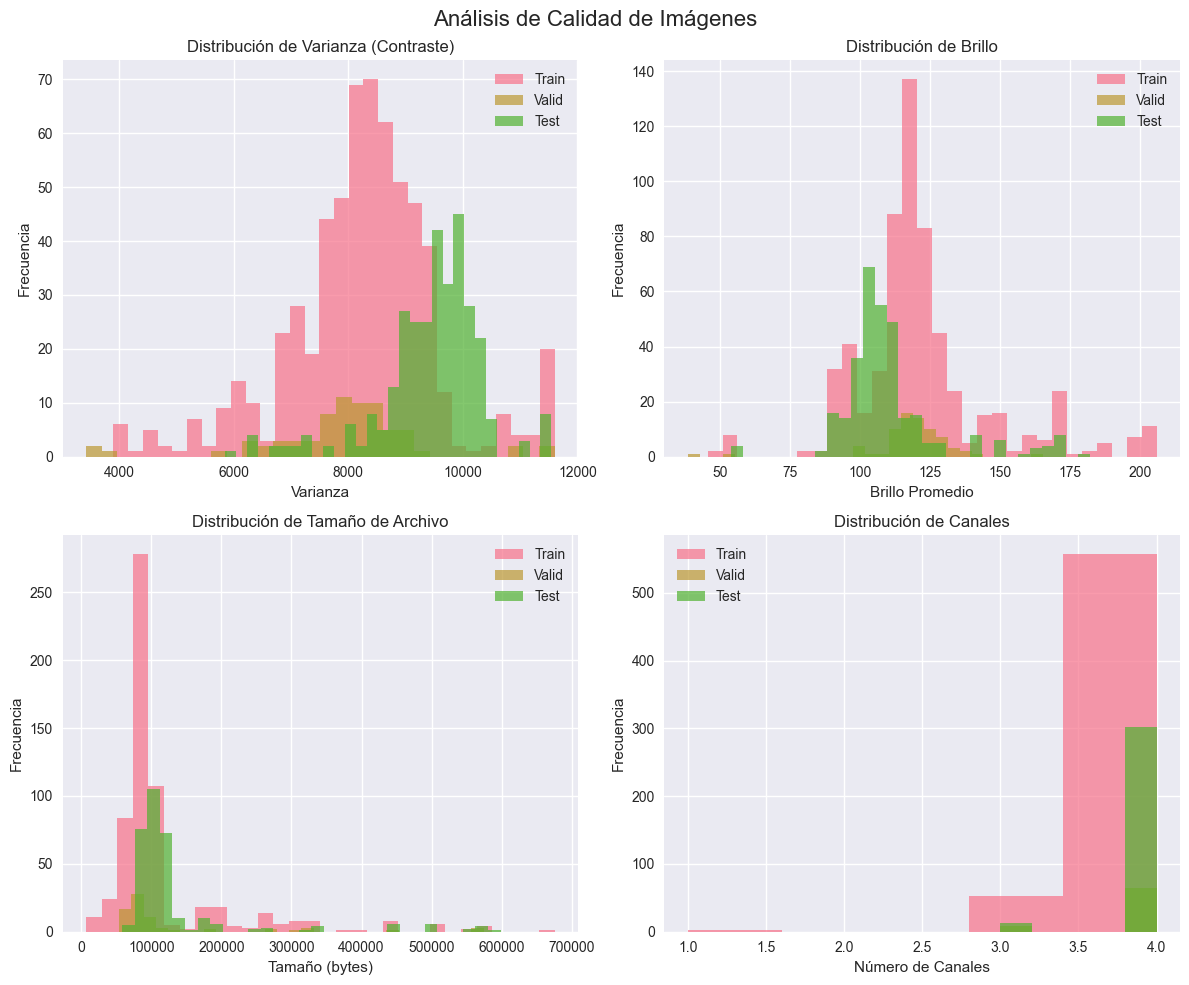

In [40]:
def analyze_image_quality(dataset, dataset_name, sample_size=1000):
    """
    Analiza la calidad de las imágenes en un dataset
    """
    quality_metrics = []
    
    # Tomar una muestra razonable de imágenes
    max_samples = min(sample_size, len(dataset))
    
    print(f"Procesando {max_samples} imágenes de calidad del dataset {dataset_name}...")
    
    for i in range(max_samples):
        try:
            # Obtener la imagen sin transformación para análisis de calidad
            img_path = dataset.samples[i][0]
            
            with Image.open(img_path) as img:
                # Calcular métricas de calidad
                quality_info = {
                    'file_size': os.path.getsize(img_path),
                    'channels': img.mode.count('RGB') if img.mode == 'RGB' else 1,
                    'brightness': np.mean(np.array(img)),
                    'variance': np.var(np.array(img))
                }
                
                # Para imágenes en escala de grises o RGBA, calcular con más cuidado
                if img.mode in ['L', '1']:  # Escala de grises o binaria
                    quality_info['channels'] = 1
                elif img.mode == 'RGBA':
                    quality_info['channels'] = 4
                elif img.mode == 'RGB':
                    quality_info['channels'] = 3
                
                quality_metrics.append(quality_info)
                
        except Exception as e:
            print(f"Error procesando imagen {i}: {e}")
            continue
    
    return quality_metrics


print("\n=== ANÁLISIS DE CALIDAD ===")
# Analizar calidad de cada conjunto
train_quality = analyze_image_quality(train_dataset, "Train")
valid_quality = analyze_image_quality(valid_dataset, "Valid")
test_quality = analyze_image_quality(test_dataset, "Test")

print("\nAnálisis de calidad del dataset de entrenamiento:")
if train_quality:
    print(f"  Muestras procesadas: {len(train_quality)}")
    print(f"  Varianza promedio: {np.mean([q['variance'] for q in train_quality]):.2f}")
    print(f"  Brillo promedio: {np.mean([q['brightness'] for q in train_quality]):.2f}")
    print(f"  Tamaño promedio de archivo: {np.mean([q['file_size'] for q in train_quality]):.0f} bytes")

print("\nAnálisis de calidad del dataset de validación:")
if valid_quality:
    print(f"  Muestras procesadas: {len(valid_quality)}")
    print(f"  Varianza promedio: {np.mean([q['variance'] for q in valid_quality]):.2f}")
    print(f"  Brillo promedio: {np.mean([q['brightness'] for q in valid_quality]):.2f}")
    print(f"  Tamaño promedio de archivo: {np.mean([q['file_size'] for q in valid_quality]):.0f} bytes")

print("\nAnálisis de calidad del dataset de prueba:")
if test_quality:
    print(f"  Muestras procesadas: {len(test_quality)}")
    print(f"  Varianza promedio: {np.mean([q['variance'] for q in test_quality]):.2f}")
    print(f"  Brillo promedio: {np.mean([q['brightness'] for q in test_quality]):.2f}")
    print(f"  Tamaño promedio de archivo: {np.mean([q['file_size'] for q in test_quality]):.0f} bytes")

# Visualización de calidad
fig2, axes2 = plt.subplots(2, 2, figsize=(12, 10))
fig2.suptitle('Análisis de Calidad de Imágenes', fontsize=16)

# Histograma de varianza (contraste)
if train_quality:
    axes2[0,0].hist([q['variance'] for q in train_quality], alpha=0.7, label='Train', bins=30)
    axes2[0,0].hist([q['variance'] for q in valid_quality], alpha=0.7, label='Valid', bins=30)
    axes2[0,0].hist([q['variance'] for q in test_quality], alpha=0.7, label='Test', bins=30)
    axes2[0,0].set_title('Distribución de Varianza (Contraste)')
    axes2[0,0].set_xlabel('Varianza')
    axes2[0,0].set_ylabel('Frecuencia')
    axes2[0,0].legend()

# Histograma de brillo
if train_quality:
    axes2[0,1].hist([q['brightness'] for q in train_quality], alpha=0.7, label='Train', bins=30)
    axes2[0,1].hist([q['brightness'] for q in valid_quality], alpha=0.7, label='Valid', bins=30)
    axes2[0,1].hist([q['brightness'] for q in test_quality], alpha=0.7, label='Test', bins=30)
    axes2[0,1].set_title('Distribución de Brillo')
    axes2[0,1].set_xlabel('Brillo Promedio')
    axes2[0,1].set_ylabel('Frecuencia')
    axes2[0,1].legend()

# Histograma de tamaño de archivo
if train_quality:
    axes2[1,0].hist([q['file_size'] for q in train_quality], alpha=0.7, label='Train', bins=30)
    axes2[1,0].hist([q['file_size'] for q in valid_quality], alpha=0.7, label='Valid', bins=30)
    axes2[1,0].hist([q['file_size'] for q in test_quality], alpha=0.7, label='Test', bins=30)
    axes2[1,0].set_title('Distribución de Tamaño de Archivo')
    axes2[1,0].set_xlabel('Tamaño (bytes)')
    axes2[1,0].set_ylabel('Frecuencia')
    axes2[1,0].legend()

# Histograma de canales
if train_quality:
    axes2[1,1].hist([q['channels'] for q in train_quality], alpha=0.7, label='Train', bins=5)
    axes2[1,1].hist([q['channels'] for q in valid_quality], alpha=0.7, label='Valid', bins=5)
    axes2[1,1].hist([q['channels'] for q in test_quality], alpha=0.7, label='Test', bins=5)
    axes2[1,1].set_title('Distribución de Canales')
    axes2[1,1].set_xlabel('Número de Canales')
    axes2[1,1].set_ylabel('Frecuencia')
    axes2[1,1].legend()

plt.tight_layout()
plt.show()




### Métricas de calidad por conjunto:

**Dataset Train:**
- Muestras procesadas: 613
- Varianza promedio: 8244.66
- Brillo promedio: 122.18
- Tamaño promedio de archivo: 118242 bytes

**Dataset Valid:**
- Muestras procesadas: 72
- Varianza promedio: 7921.69
- Brillo promedio: 118.49
- Tamaño promedio de archivo: 127609 bytes

**Dataset Test:**
- Muestras procesadas: 315
- Varianza promedio: 9465.25
- Brillo promedio: 110.43
- Tamaño promedio de archivo: 137418 bytes

### Principales hallazgos:

La varianza promedio es más alta en el conjunto Train (8244.66) comparado con Valid (7921.69) y Test (9465.25). El brillo promedio es más alto en Train (122.18) que en Valid (118.49) y Test (110.43).

Los tamaños de archivos varían entre conjuntos, con valores que van desde 118KB (Train) hasta 137KB (Test).

### Recomendaciones:

1. Preprocesamiento estandarizado para normalizar brillo y contraste entre conjuntos
2. Redimensionamiento a tamaño estándar para consistencia
3. Validación de impacto del rango de brillo en rendimiento del modelo

